<a href="https://colab.research.google.com/github/dennis-ancajima/ML-PUCP/blob/main/Estimaci%C3%B3n_de_los_niveles_de_obesidad_LBase_Sin_IMC_LabelEncoder_12_caracteristicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
import seaborn as sns #Libreria para gráficar
from sklearn.model_selection import cross_val_score
from google.colab import drive

pd.set_option("display.max_columns", 50)

%matplotlib inline
plt.style.use('ggplot')

In [4]:
#Lectura del dataset
file_name = "ObesityDataSet_raw_and_data_sinthetic.csv"

#El método "read_csv" nos permite leer un excel
dataset = pd.read_csv(file_name)

In [5]:
dataset.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [ ]:
#Revisando duplicados
dataset.duplicated().sum()

24

In [ ]:
#Eliminar duplicados
#dataset.drop_duplicates(inplace=True)

# Aplicamos LabelEncoder para análisis Feature Extraction with PCA

In [6]:
#LabelEncoder
from sklearn.preprocessing import LabelEncoder

cols_categoricas = ['CAEC','CALC','MTRANS','FAVC', 'SMOKE', 'SCC','family_history_with_overweight','Gender','NObeyesdad']

# process columns, apply LabelEncoder to categorical features
for c in cols_categoricas:
    lbl = LabelEncoder()
    # Transformar una variable categórica en valores numéricos
    dataset[c] = lbl.fit_transform(dataset[c]) #dataset[c+'_code'] = lbl.fit_transform(dataset[c]) Para revisar la codificación inverse_transform
# shape
print('Shape all_data: {}'.format(dataset.shape))

Shape all_data: (2111, 17)


# Análisis PCA: Análisis de Componentes Principales

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html We will use principle component analysis (PCA) for feature extraction. Before PCA, we need to normalize data for better performance of PCA.

Reference: https://www.kaggle.com/code/kanncaa1/feature-selection-and-data-visualization

Observamos la media de las características númericas.

In [7]:
dataset.mean()

Gender                             0.505921
Age                               24.312600
Height                             1.701677
Weight                            86.586058
family_history_with_overweight     0.817622
FAVC                               0.883941
FCVC                               2.419043
NCP                                2.685628
CAEC                               1.859308
SMOKE                              0.020843
CH2O                               2.008011
SCC                                0.045476
FAF                                1.010298
TUE                                0.657866
CALC                               2.268593
MTRANS                             2.365230
NObeyesdad                         3.015632
dtype: float64

Observamos la varianza de las características númericas.

In [8]:
dataset.var()

Gender                              0.250083
Age                                40.271313
Height                              0.008706
Weight                            685.977477
family_history_with_overweight      0.149187
FAVC                                0.102638
FCVC                                0.285078
NCP                                 0.605344
CAEC                                0.219533
SMOKE                               0.020418
CH2O                                0.375712
SCC                                 0.043429
FAF                                 0.723507
TUE                                 0.370792
CALC                                0.265738
MTRANS                              1.591189
NObeyesdad                          3.810656
dtype: float64

1. Se debe escalar los datos antes de realizar el análisis PCA: media 0 y varianza 1. Así pues, es importante estandarizar las variables con una media de cero y una desviación estándar de 1 antes de realizar PCA. Podemos hacerlo usando la función scale de sklearn:

In [9]:
#Separamos la data, en variables independientes (x) y dependientes (y), para poder entrenar el modelo de regresión
X_train_val = dataset.drop(['NObeyesdad'], axis=1)
y_train_val = dataset['NObeyesdad']

In [10]:
# Dividimos la data en conjunto de "entrenamiento" y "prueba"
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

In [11]:
#normalization
x_train_N = (X_train-X_train.mean())/(X_train.max()-X_train.min())
x_test_N = (X_val-X_val.mean())/(X_val.max()-X_val.min())


Text(0, 0.5, 'explained_variance_ratio_')

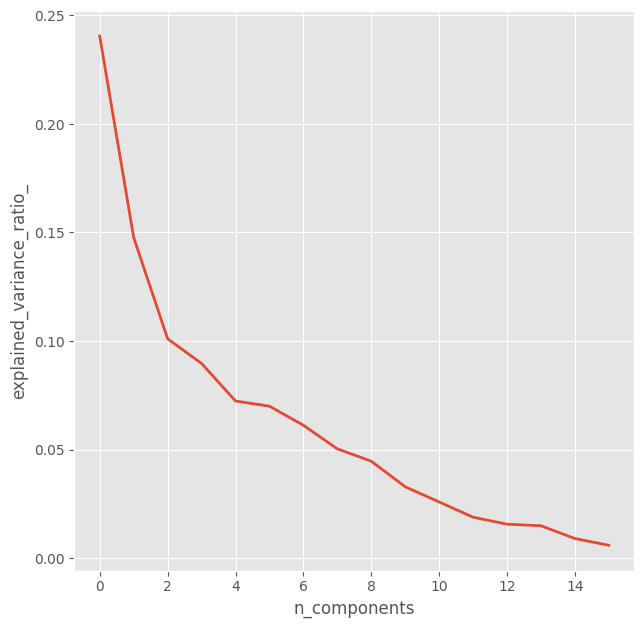

In [12]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train_N)

plt.figure(1, figsize=(8, 8))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

Se observa que las últimas 4 caracteristicas: CALC, MTRANS, FCVC, family_history_with_overweight pueden ser campos irrelevantes para efectos de la predicción según (PCA).

# Selección Y Extracción De Características por filtrado

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

In [14]:
#X_train_val, y_train_val
X_train_val.shape

(2111, 16)

Seleccionamos las mejores 12 características (K=12)

In [15]:
filtrado = SelectKBest(mutual_info_classif, k=16).fit(X_train_val, y_train_val)

In [16]:
filtrado.scores_

array([1.95213410e-01, 5.93737877e-01, 4.21830894e-01, 1.25423842e+00,
       1.46803720e-01, 5.46216225e-02, 3.85479075e-01, 2.46302122e-01,
       1.60181934e-01, 5.41209697e-04, 2.97097573e-01, 3.49207527e-02,
       2.97017916e-01, 2.77444396e-01, 9.88593602e-02, 6.07624311e-02])

Obtenemos los nombres de las características seleccionadas:

In [17]:
filtrado.get_feature_names_out()

array(['Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS'],
      dtype=object)

In [18]:
print('Score list:', filtrado.scores_)
print('Feature list:', X_train_val.columns)

Score list: [1.95213410e-01 5.93737877e-01 4.21830894e-01 1.25423842e+00
 1.46803720e-01 5.46216225e-02 3.85479075e-01 2.46302122e-01
 1.60181934e-01 5.41209697e-04 2.97097573e-01 3.49207527e-02
 2.97017916e-01 2.77444396e-01 9.88593602e-02 6.07624311e-02]
Feature list: Index(['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight',
       'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE',
       'CALC', 'MTRANS'],
      dtype='object')


In [19]:
X_new = filtrado.transform(X_train_val)
X_new[:5]

array([[ 0.  , 21.  ,  1.62, 64.  ,  1.  ,  0.  ,  2.  ,  3.  ,  2.  ,
         0.  ,  2.  ,  0.  ,  0.  ,  1.  ,  3.  ,  3.  ],
       [ 0.  , 21.  ,  1.52, 56.  ,  1.  ,  0.  ,  3.  ,  3.  ,  2.  ,
         1.  ,  3.  ,  1.  ,  3.  ,  0.  ,  2.  ,  3.  ],
       [ 1.  , 23.  ,  1.8 , 77.  ,  1.  ,  0.  ,  2.  ,  3.  ,  2.  ,
         0.  ,  2.  ,  0.  ,  2.  ,  1.  ,  1.  ,  3.  ],
       [ 1.  , 27.  ,  1.8 , 87.  ,  0.  ,  0.  ,  3.  ,  3.  ,  2.  ,
         0.  ,  2.  ,  0.  ,  2.  ,  0.  ,  1.  ,  4.  ],
       [ 1.  , 22.  ,  1.78, 89.8 ,  0.  ,  0.  ,  2.  ,  1.  ,  2.  ,
         0.  ,  2.  ,  0.  ,  0.  ,  0.  ,  2.  ,  3.  ]])

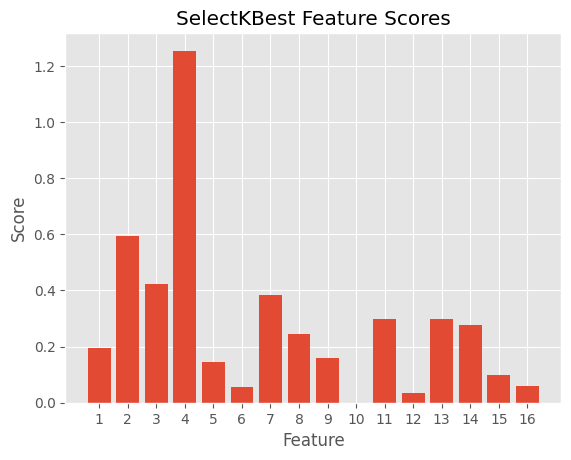

In [20]:
plt.bar(range(len(filtrado.scores_)), filtrado.scores_)
plt.xticks(range(len(filtrado.scores_)), range(1, len(filtrado.scores_)+1))
plt.xlabel('Feature')
plt.ylabel('Score')
plt.title('SelectKBest Feature Scores')
plt.show()

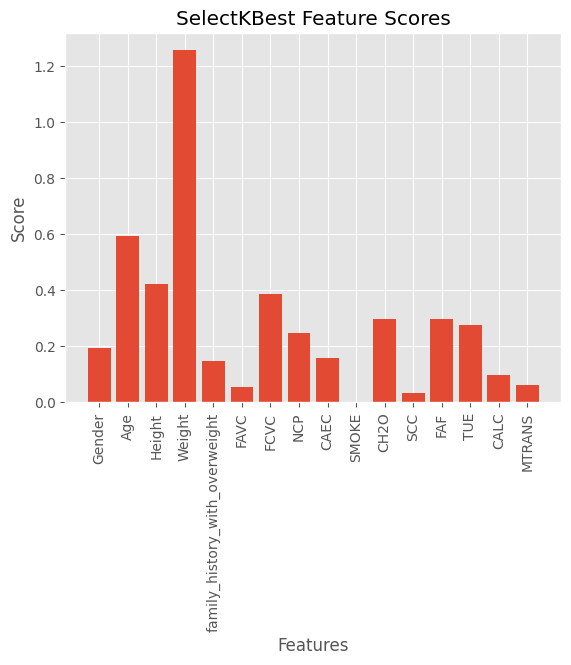

In [21]:
plt.bar(range(len(filtrado.scores_)), filtrado.scores_)
plt.xticks(range(len(filtrado.scores_)), filtrado.get_feature_names_out(), rotation=90)
plt.xlabel('Features')
plt.ylabel('Score')
plt.title('SelectKBest Feature Scores')
plt.show()

In [22]:
#Renombrando etiquetas:

# Diccionario de mapeo de nombres de características
mapping = {
    'Gender': 'Género',
    'Age': 'Edad',
    'Height': 'Altura',
    'Weight': 'Peso',
    'family_history_with_overweight':'Pariente c/obesidad',
    'FAVC': 'A. hipercalóricos',
    'FCVC': 'C. Vegetales',
    'NCP': 'N. Comidas',
    'CAEC': 'A. Entre Comidas',
    'SMOKE': 'Fumar',
    'CH2O': 'C. agua',
    'SCC': 'Monit. Calorias',
    'FAF': 'Actividad física',
    'TUE': 'Uso Dispositivo Tec.',
    'CALC': 'Alcohol',
    'MTRANS': 'Transporte usado',

}

# Renombrar los nombres de características
renamed_feature_names = [mapping.get(name, name) for name in filtrado.get_feature_names_out()]

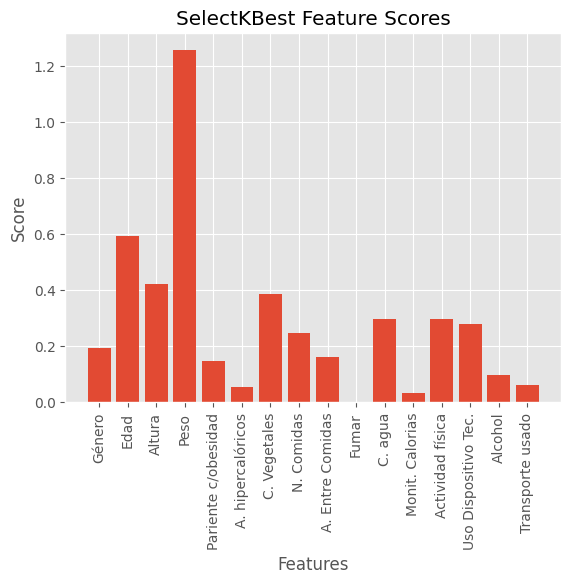

In [23]:
plt.bar(range(len(filtrado.scores_)), filtrado.scores_)
plt.xticks(range(len(filtrado.scores_)), renamed_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Score')
plt.title('SelectKBest Feature Scores')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

4 características menos importantes: Smoke, FAVC, SCC, MTRANS

# Selección de características por wrapping - Backward elimination

In [ ]:
# Ver https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000, n_features=25, n_informative=3,
                           n_redundant=2, n_repeated=0, n_classes=8,
                           n_clusters_per_class=1, random_state=0)

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(10),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

KeyboardInterrupt: ignored

# Eliminar 4 características

In [ ]:
dataset.drop(['CALC','MTRANS','FCVC','family_history_with_overweight'], axis=1, inplace=True)

In [ ]:
dataset.head()

# **12 atributos sin IMC**

# División de datos de entrenamiento y test

In [ ]:
#Separamos la data, en variables independientes (x) y dependientes (y), para poder entrenar el modelo de regresión
X_train_val = dataset.drop(['NObeyesdad'], axis=1)
y_train_val = dataset['NObeyesdad']

In [ ]:
# Dividimos la data en conjunto de "entrenamiento" y "prueba"
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

In [ ]:
#12 características
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_val.shape}")

Train shape: (1688, 12)
Test shape: (423, 12)


In [ ]:
#Escalar datos
scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train) #Escalar los datos de entrenamiento
X_val_scal = scaler.fit_transform(X_val) #Escalar los datos de prueba

# Ensamble por votación manual

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm

estimators = [
     ('Random Forest', make_pipeline(StandardScaler(), RandomForestClassifier(oob_score = True, random_state=42))),
     ('SVM Cubic', make_pipeline(StandardScaler(),svm.SVC(kernel='poly', degree=3,C=10, gamma=50,probability=True))),

     ('árbol de decisión', DecisionTreeClassifier(max_depth=4)),
     ('k-NN', make_pipeline(StandardScaler(),
                            KNeighborsClassifier(n_neighbors=7) )),
     ('SVM de kernel gaussiano', make_pipeline(StandardScaler(),
                                               SVC(kernel='rbf', probability=True) ))
]

ensamble = VotingClassifier(estimators=estimators,
                        voting='soft', weights=[3,2,2, 1, 2])
ensamble.fit(X_train, y_train)

for (name, estimator) in ensamble.named_estimators_.items():
  print(f'Exactitud de {name: <25}: Entrenamiento {estimator.score(X_train, y_train):.03f} || Pruebas {estimator.score(X_val, y_val):.03f}',  )

print(f'Exactitud de {"ensamble": <25}: Entrenamiento {ensamble.score(X_train, y_train):.03f} || Validación {ensamble.score(X_val, y_val):.03f}' )

Exactitud de Random Forest            : Entrenamiento 1.000 || Pruebas 0.953
Exactitud de SVM Cubic                : Entrenamiento 1.000 || Pruebas 0.896
Exactitud de árbol de decisión        : Entrenamiento 0.803 || Pruebas 0.785
Exactitud de k-NN                     : Entrenamiento 0.837 || Pruebas 0.766
Exactitud de SVM de kernel gaussiano  : Entrenamiento 0.927 || Pruebas 0.896
Exactitud de ensamble                 : Entrenamiento 0.993 || Validación 0.931


**SVM CUBIC**

**C=10, gamma=50**

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

# Crear una instancia del clasificador SVM con kernel cúbico
model = svm.SVC(kernel='poly', degree=3,C=10, gamma=50)

# Entrenar el clasificador
model.fit(X_train_scal, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_val_scal)

cv = cross_val_score(estimator = model, X = X_train_scal, y = y_train, cv = 10) #metodo para obtener la precisión
cvForest = cv.mean()
stdForest = cv.std()


print("promedio Validación cruzada k=10: ", cvForest)
print('Varianza de Random Forest: ',stdForest)
print ('Exactitud en el conjunto de entrenamiento: %0.4f' % model.score(X_train_scal, y_train))
print ('Exactitud en el conjunto de validación: %0.4f' % model.score(X_val_scal, y_val))

Para determinar valores C y γ que brinden una mejor generalización, es necesario probar con diferentes valores, ajustando el modelo en el conjunto de entrenamiento y probando su desempeño en el conjunto de validación.

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

Cs = np.logspace(-2,2,9)  # ~ [0.01, 0.03, 0.1, ..., 100]
gammas = np.logspace(-4,4,9)  # [0.0001, 0.001, ..., 10000]

mejor_modelo = None
mejor_score = 0
for C in Cs:
    for gamma in gammas:

        model = svm.SVC(kernel='poly', degree=3, C=C, gamma=gamma)
        model.fit(X_train_scal, y_train)

        score_val = model.score(X_val_scal, y_val)

        if score_val > mejor_score:
            mejor_score = score_val
            mejor_modelo = model


cv = cross_val_score(estimator = mejor_modelo, X = X_train_scal, y = y_train, cv = 10) #metodo para obtener la precisión
cvForest = cv.mean()

print ('Mejor valor de C: %0.4f' % mejor_modelo.get_params()['C'])
print ('Mejor valor de gamma: %0.4f' % mejor_modelo.get_params()['gamma'])
print ('Exactitud en el conjunto de entrenamiento: %0.4f' % mejor_modelo.score(X_train_scal, y_train))
print ('Exactitud en el conjunto de validación: %0.4f' % mejor_modelo.score(X_val_scal, y_val))
print("promedio Validación cruzada k=10: ", cvForest)


**RandomForest con data escalada: OOB (Bagging)**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(oob_score = True,random_state=42)
rf.fit(X_train_scal, y_train)

y_pred = rf.predict(X_val_scal) #Hacemos predicciones sobre el conjunto de test

cv = cross_val_score(estimator = rf, X = X_train_scal, y = y_train, cv = 10) #metodo para obtener la precisión
cvForest = cv.mean()
stdForest = cv.std()
print('Exactitud del modelo inicial en entrenamiento:', rf.score(X_train_scal, y_train))
print('Exactitud del modelo inicial en entrenamiento (Out of Bag):', rf.oob_score_)
print('Exactitud del modelo inicial en validación:', rf.score(X_val_scal, y_val))
print("promedio Validación cruzada Random Forest: ", cvForest)
print('Varianza de Random Forest: ',stdForest)

# Matriz de confusión

In [ ]:
cm = confusion_matrix(y_val, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()

# Importancia de la características

In [ ]:
feature_names = X_train_val.columns.values
tree_feature_importances = rf.feature_importances_
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Importancia de características")
fig.tight_layout()
plt.show()

** Estrategia De Validación A Emplear Para El Ajuste De Hiperparámetros.**

Los principales hiperparámetros de Random Forest son:

n_estimators -- el número de modelos base (árboles) a entrenar
max_features -- el número de características a considerar en cada partición de los árboles
max_depth -- la profundidad máxima de los árboles
min_samples_leaf -- el numero mínimo de muestras que deben quedar en cada hoja del árbol
Para identificar los mejores valores de los hiperparámetros usaremos primero búsqueda aleatoria y luego búsqueda en grilla.

In [ ]:
from pprint import pprint
import numpy as np

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 8, 10, 12, None]  # 'auto' equivale a 'sqrt'; None equivale a todas las 15
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] + [None]
min_samples_leaf = [1, 2, 4]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

print('Los valores a probar en la búsqueda aleatoria son:')
pprint(random_grid)

print()
print('Si se probara todas las combinaciones se requeriría entrenar',
      len(random_grid['n_estimators']) *
      len(random_grid['max_features']) *
      len(random_grid['max_depth']) *
      len(random_grid['min_samples_leaf']),
      'modelos'
      )

Probaremos entrenando sólo un 1% de las combinaciones posibles, es decir, 18. (Se recomienda probar al menos un 10%)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(oob_score=True)
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 18,
                               cv = 10,          # Validación cruzada 10-fold
                               verbose=2,
                               random_state=0,
                               n_jobs = -1      # Paralelizar en todos los cores disponibles
                               )
rf_random.fit(X_train_scal, y_train)

In [ ]:
rf_random_best = rf_random.best_estimator_

print('Los hiperparámetros del mejor modelo son:')
pprint(rf_random.best_params_)
print()

print('Exactitud luego de búsqueda aleatoria en entrenamiento:', rf_random_best.score(X_train_scal, y_train))
print('Exactitud luego de búsqueda aleatoria en entrenamiento (Out of Bag):', rf_random_best.oob_score_)
print('Exactitud luego de búsqueda aleatoria en validación:', rf_random_best.score(X_val_scal, y_val))